# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product
import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [3]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':12,
    'stickiness_wi':20000,
    'stickiness_bt':6, # 100
    'sparsity':1,
    'pvar': 0.5,
    'lrate':1,
    'lratep':1,
    'decay_rate':1,
} 
semargs = {
  'beta2':False
}
args = {
    'sem':semargs,
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str += "-"+"-".join(["%s_%.3f"%(i,j) for i,j in semargs.items()])
param_str

'concentration_12.000-stickiness_wi_20000.000-stickiness_bt_6.000-sparsity_1.000-pvar_0.500-lrate_1.000-lratep_1.000-decay_rate_1.000-beta2_0.000'

In [4]:
# p_name = 'concentration' # 
# p_vals = np.arange(5,15,0.5)

# p_name = 'stickiness_wi' # 5000
# p_vals = np.arange(0,100000,10000)

p_name = 'stickiness_bt' # 100
p_vals = np.arange(12,14,0.25)

# p_name = 'sparsity' # 0.08
# p_vals = np.arange(0.01,0.5,0.05)

# p_name = 'pvar' # 0
# p_vals = np.arange(1,2,0.1)

# p_name = 'lrate' # 1
# p_vals = np.arange(0.5,1,0.05)

# p_name = 'lratep' # 1
# p_vals = np.arange(0.8,1.05,0.01)

# p_name = 'decay_rate' # 1
# p_vals = np.arange(0.95,1.000001,0.005)

p_name,p_vals

('stickiness_bt',
 array([12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75]))

### main

In [5]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
  plt.savefig('figures/scratch_folders/%i/acc-%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None


In [6]:
ns = 15
dfL = []
condL = ['blocked','interleaved','early','middle','late']
for idx,p_val in enumerate(p_vals):
  print(idx/len(p_vals))
  
  args['sch'][p_name] = p_val  
  exp_batch_data = run_batch_exp_curr(ns,args,condL)
  ## acc
  batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
  mean_acc = batch_acc.mean(1)
  test_acc = mean_acc[:,-40:].mean(1) # curr  
  
  ## save traces of EML for each param setting
  pltsave_macc(mean_acc[2:],args['sch'],labL=['E','M','L'])
  
  ## record
  gsD = {
    **schargs,
    **dict(zip(condL,test_acc))
  }
  dfL.append(gsD)
  
gsdf = pd.DataFrame(dfL)

0.0
0.125
0.25
0.375
0.5
0.625
0.75
0.875


In [7]:
gsdf ## test acc dataframe

,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late
0,12,20000,12.00,1,0.5,1,1,1,1.0,0.500000,1.0,0.500000,0.500000
1,12,20000,12.25,1,0.5,1,1,1,1.0,0.500000,1.0,0.500000,0.500000
2,12,20000,12.50,1,0.5,1,1,1,1.0,0.500000,1.0,0.500000,0.500000
3,12,20000,12.75,1,0.5,1,1,1,1.0,0.500000,1.0,0.500000,0.500000
4,12,20000,13.00,1,0.5,1,1,1,1.0,0.500000,1.0,0.500000,0.500000
5,12,20000,13.25,1,0.5,1,1,1,1.0,0.494583,1.0,0.490000,0.502083
6,12,20000,13.50,1,0.5,1,1,1,1.0,0.483750,1.0,0.493333,0.492917
7,12,20000,13.75,1,0.5,1,1,1,1.0,0.511667,1.0,0.502917,0.483333


### plt 

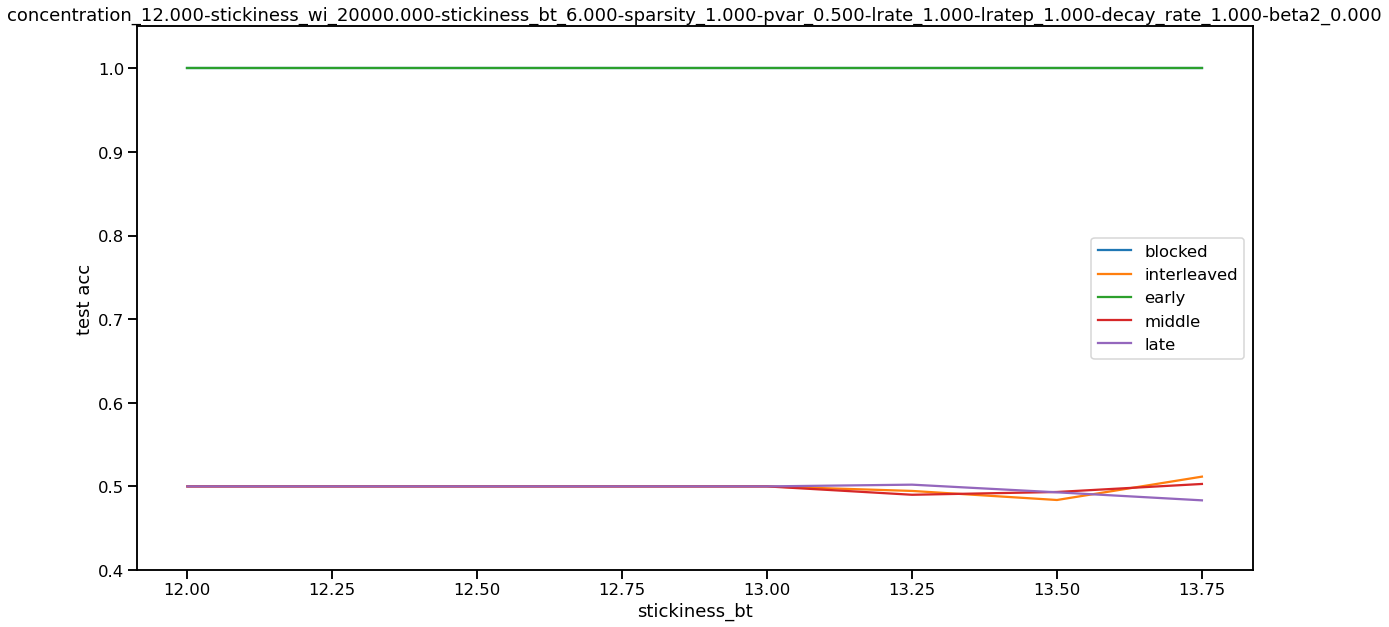

In [8]:
plt.figure(figsize=(20,10))
ax = plt.gca()
gsdf.plot(p_name,condL,ax=ax)
ax.set_ylim(0.4,1.05)
ax.set_ylabel('test acc')
plt.title(param_str)
plt.savefig('figures/scratch/testacc-sweep_%s-default_%s-t%s.png'%(
  p_name,param_str,tstamp))